In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import os.path as path

import tensorflow as tf
import keras
from keras import Input
from keras.layers import Dense, \
                         Dropout

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from BPNN import BPNN

In [2]:
dataset_path = r"./dat/data-set-2016-TiO2/"

In [3]:
def check_periodics():
    count = 0

    # ripped and slightly modified from xsf_clean.py
    for s_no in range(1, 7816):
        file = path.join(
            dataset_path,
            f"structure{str(s_no).zfill(4)}.xsf"
        )
    
        with open(file, "r") as f:
            lines = f.readlines()
            if "PRIMVEC\n" in lines:
                count += 1

    print(f"number of periodic structures: {count}")

check_periodics()

number of periodic structures: 7815


In [4]:
scaler = StandardScaler()

N_SYSTEMS = 265

# read all systems
X = np.array(
    [
        pd.read_csv(
            f"./dat/symmetries/sym{str(idx).zfill(4)}.csv"
        ).to_numpy()
        for idx in range(1, N_SYSTEMS + 1)
    ]
)[:, :26, :]
# symmetries with 25 rows were 

for idx, x in enumerate(X):
    X[idx] = scaler.fit_transform(x)

# read energy file
y = pd.read_csv(
    "./dat/energies.csv"
)[0:N_SYSTEMS]

In [5]:
X, y = shuffle(X, y)

lo = int(0.6 * N_SYSTEMS)
hi = int(0.8 * N_SYSTEMS)

X_train = X[:lo]
X_val   = X[lo:hi]
X_test  = X[hi:]

y_train = y[:lo]
y_val   = y[lo:hi]
y_test  = y[hi:]

In [6]:
model = BPNN([
        Dense(16, activation = "relu"),
        Dense(32, activation = "relu"),
        Dense(16, activation = "relu")
    ])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = keras.losses.MeanAbsoluteError(),
    metrics = [keras.metrics.RootMeanSquaredError()]
)

In [7]:
n_epochs = 100
batch_sz = 10

bpnn = model.fit(
    X_train, y_train,
    batch_size = batch_sz,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 0
)

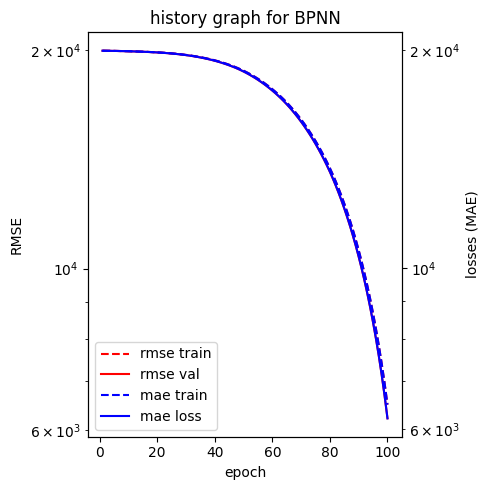

In [8]:
import matplotlib.pyplot as plt

xax = np.arange(1, n_epochs + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
ax.set_title("history graph for BPNN")
ax.set_xlabel("epoch")

tax = ax.twinx()

tax.set_ylabel("losses (MAE)")
ax.set_ylabel("RMSE")

ax.plot(
    xax, 
    bpnn.history["root_mean_squared_error"],
    "r--",
    label = "rmse train"
)

ax.plot(
    xax,
    bpnn.history["val_root_mean_squared_error"],
    "r-",
    label = "rmse val"
)

tax.plot(
    xax, 
    bpnn.history["loss"],
    "b--",
    label = "mae train"
)

tax.plot(
    xax, 
    bpnn.history["val_loss"],
    "b",
    label = "mae loss"
)


ax.set_yscale("log")
tax.set_yscale("log")

lns = [*ax.lines, *tax.lines]
labels = [ln.get_label() for ln in lns]

ax.legend(lns, labels)
plt.tight_layout()
plt.show()

In [9]:
preds = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


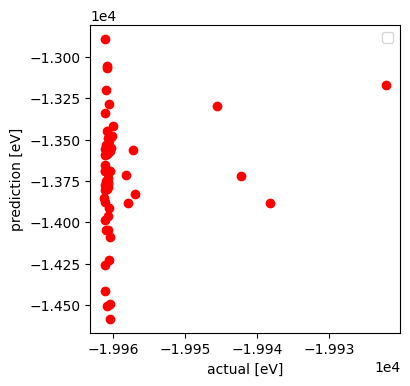

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
ax.set_ylabel("prediction [eV]")
ax.set_xlabel("actual [eV]")
ax.ticklabel_format(axis = "both", style="sci", scilimits=(0,0))

y = y_test.to_numpy()
ax.scatter(y, preds, marker = "o", c="red")

plt.legend()
plt.show()

# Tuned plots

In [11]:
import keras_tuner

def build_model(hp):
    tf.keras.backend.clear_session()
    n_layers = hp.Choice("layers", [3, 4])
    units    = hp.Choice("units", [25, 50])
    lrs      = hp.Choice("rates", [0.001, 0.0001])

    layers = []
    for _ in range(n_layers):
        layers.append(
            Dense(units, activation = "relu")
        )
        layers.append(
            Dropout(0.1)
        )

    model = BPNN(layers)

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lrs),
        loss = keras.losses.MeanAbsoluteError(),
        metrics = [keras.metrics.RootMeanSquaredError()]
    )

    return model

In [12]:
tuner = keras_tuner.GridSearch(
    build_model,
    objective = "val_root_mean_squared_error",
    max_trials = 8
)

tuner.search(
    X_train, y_train,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 1
)

Trial 8 Complete [00h 00m 15s]
val_root_mean_squared_error: 8622.7626953125

Best val_root_mean_squared_error So Far: 556.7062377929688
Total elapsed time: 00h 01m 49s


In [13]:
tuned_hp = tuner.get_best_hyperparameters()[0]
tf.keras.backend.clear_session()
m_tuned = tuner.hypermodel.build(tuned_hp)
bpnn_tuned = m_tuned.fit(
    X_train, y_train,
    batch_size = batch_sz,
    epochs = n_epochs,
    validation_data = (X_val, y_val),
    verbose = 1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 19948.9824 - root_mean_squared_error: 19948.9844 - val_loss: 19911.1172 - val_root_mean_squared_error: 19911.1191
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19876.8848 - root_mean_squared_error: 19876.9082 - val_loss: 19709.3496 - val_root_mean_squared_error: 19709.3496
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19548.7871 - root_mean_squared_error: 19549.3340 - val_loss: 18738.7832 - val_root_mean_squared_error: 18738.8066
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18053.5254 - root_mean_squared_error: 18064.5664 - val_loss: 14657.0117 - val_root_mean_squared_error: 14657.7500
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12148.9336 - root_mean_squared_error: 12384.9639 - val_loss: 631.9644 - val_root_mean_squared_error: 746.3210
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1887.7625 - root_mean_squared_error: 2270.6094 - val_loss: 1671.0208 - val_root

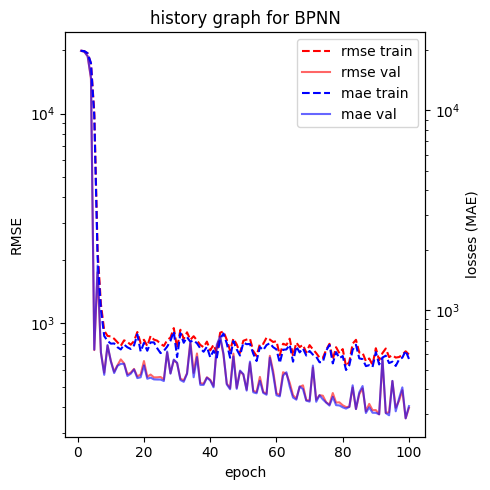

In [14]:
import matplotlib.pyplot as plt

xax = np.arange(1, n_epochs + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
ax.set_title("history graph for BPNN")
ax.set_xlabel("epoch")

tax = ax.twinx()

tax.set_ylabel("losses (MAE)")
ax.set_ylabel("RMSE")

ax.plot(
    xax, 
    bpnn_tuned.history["root_mean_squared_error"],
    "r--",
    label = "rmse train"
)

ax.plot(
    xax,
    bpnn_tuned.history["val_root_mean_squared_error"],
    "r-",
    alpha = 0.6,
    label = "rmse val"
)

tax.plot(
    xax, 
    bpnn_tuned.history["loss"],
    "b--",
    label = "mae train"
)

tax.plot(
    xax, 
    bpnn_tuned.history["val_loss"],
    "b",
    alpha = 0.6,
    label = "mae val"
)


ax.set_yscale("log")
tax.set_yscale("log")

lns = [*ax.lines, *tax.lines]
labels = [ln.get_label() for ln in lns]

ax.legend(lns, labels)
plt.tight_layout()
plt.show()

In [15]:
preds = m_tuned.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step


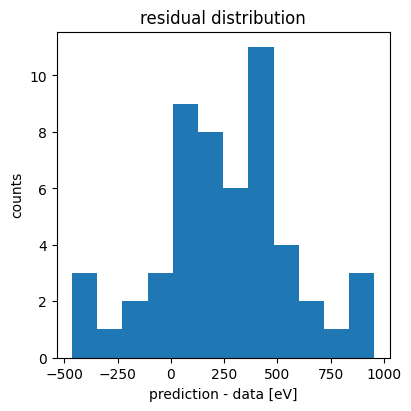

In [16]:
y = y_test.to_numpy().reshape(-1)
diff = preds - y
all_vals = np.append(preds, y)

fig, ax = plt.subplots(
    nrows = 1, 
    ncols = 1, 
    figsize = (4,4), 
    constrained_layout = True
)

ax.set_title("residual distribution")
ax.set_xlabel("prediction - data [eV]")
ax.set_ylabel("counts")
ax.hist(diff, bins = 12)

plt.show()